In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCELoss, MSELoss, L1Loss
import torch.optim as optim
from tqdm import tqdm

In [16]:
path = '/home/shrestha/python_project/datasets/biopharma_activity.csv'
data = pd.read_csv(path , on_bad_lines='skip')
# data = pd.read_csv(path , error_bad_lines=False) #IF ABOVE LINE GIVES ERROR UNCOMMENT THIS LINE AND COMMENT OUT ABOVE LINE AND THEN RUN
data = data.dropna(subset=['Smiles','Standard Value','Molecular Weight','AlogP','Standard Units'])
data.reset_index(drop=True, inplace=True)
data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL205876,NaN,NaN,361.83,0.0,4.99,9,O=C(Nc1ccc(Cl)cc1)c1ccccc1Cn1ccc2cccnc21,IC50,>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1139022,1,Scientific Literature,Bioorg Med Chem Lett,2006.0,NaN,NaN,NaN
1,CHEMBL201090,NaN,NaN,406.39,0.0,3.39,16a,COc1ccc2[nH]c3c4c(OC)c(OC)c(OC)cc4c4c(c3c2c1)C...,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
2,CHEMBL202196,NaN,NaN,338.37,0.0,3.89,20,O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1c1cccc2ccccc12,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
3,CHEMBL201463,NaN,NaN,392.41,0.0,3.07,18,COc1cc(C2=C(c3c(C)[nH]c4ccccc34)C(=O)NC2=O)cc(...,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
4,CHEMBL372944,NaN,NaN,339.35,0.0,2.28,5,COc1cc(C2=C(c3ccccc3)C(=O)NC2=O)cc(OC)c1OC,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN


In [17]:
unique_units = data['Standard Units'].unique()  #finding different units of solubility present in our data
print(unique_units)

#we can only use nM, %, uM, ug.mL-1, we drop all other values 
units_to_drop = ['%', 'hr',  'ug.mL-1', "10'-4No_unit", 'degrees C', "10'-3/s",
                 "10'5/M/s", '% ID/g', 'equiv']
data = data[~data["Standard Units"].isin(units_to_drop)]
data.reset_index(drop=True, inplace=True)
data['Standard Value'] = data.apply(lambda row:
                                    row['Standard Value'] * 1000 if row['Standard Units'] in ('µM','uM') else row['Standard Value'],axis=1)

data["Standard Units"] = 'nM'

mean_value = data["Standard Value"].mean()
std_dev = data["Standard Value"].std()

# Perform Z-score normalization
data["Standard Value"] = (data["Standard Value"] - mean_value) / std_dev

['nM' '%' 'hr' 'uM' 'ug.mL-1' "10'-4No_unit" 'degrees C' "10'-3/s"
 "10'5/M/s" '% ID/g' 'µM' 'equiv']


In [18]:
data

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL205876,NaN,NaN,361.83,0.0,4.99,9,O=C(Nc1ccc(Cl)cc1)c1ccccc1Cn1ccc2cccnc21,IC50,>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1139022,1,Scientific Literature,Bioorg Med Chem Lett,2006.0,NaN,NaN,NaN
1,CHEMBL201511,MALEIMIDE,NaN,378.38,0.0,2.76,10,COc1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=O)cc(OC)...,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,NaN,NaN,NaN
2,CHEMBL382478,NaN,NaN,404.47,1.0,5.35,36,O=C(Nc1ccc(-c2ccccc2)cc1)c1ccccc1Cn1ccc2ncnc-2c1,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1139022,1,Scientific Literature,Bioorg Med Chem Lett,2006.0,NaN,NaN,NaN
3,CHEMBL410903,NaN,NaN,442.52,1.0,5.87,37,COc1cc2nccc(Oc3ccc4c(C(=O)NC5CCCC5)cccc4c3)c2c...,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1240342,1,Scientific Literature,J Mol Graph Model,2009.0,NaN,NaN,NaN
4,CHEMBL1241777,NaN,NaN,444.49,0.0,4.77,59,COCCNC(=O)c1cccc2cc(Oc3ccnc4cc(OC)c(C(C)=O)cc3...,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1240342,1,Scientific Literature,J Mol Graph Model,2009.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15480,CHEMBL98,VORINOSTAT,4.0,264.32,0.0,2.47,1; SAHA,O=C(CCCCCCC(=O)Nc1ccccc1)NO,IC50,>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL5214883,1,Scientific Literature,Eur J Med Chem,2021.0,NaN,NaN,NaN
15481,CHEMBL24828,VANDETANIB,4.0,475.36,0.0,4.43,Vandetanib,COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL5214883,1,Scientific Literature,Eur J Med Chem,2021.0,NaN,NaN,INHIBITOR
15482,CHEMBL5174514,NaN,NaN,569.68,2.0,5.31,8,Cc1cnc(C#Cc2ccc3c4c(oc3c2)C(C)(C)c2cc(NS(C)(=O...,IC50,>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL5113522,1,Scientific Literature,J Med Chem,2022.0,NaN,NaN,NaN
15483,CHEMBL5218990,NaN,NaN,595.47,2.0,7.39,60,COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...,IC50,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL5214889,1,Scientific Literature,Eur J Med Chem,2021.0,NaN,TIME = 0.1667 hr,INHIBITOR


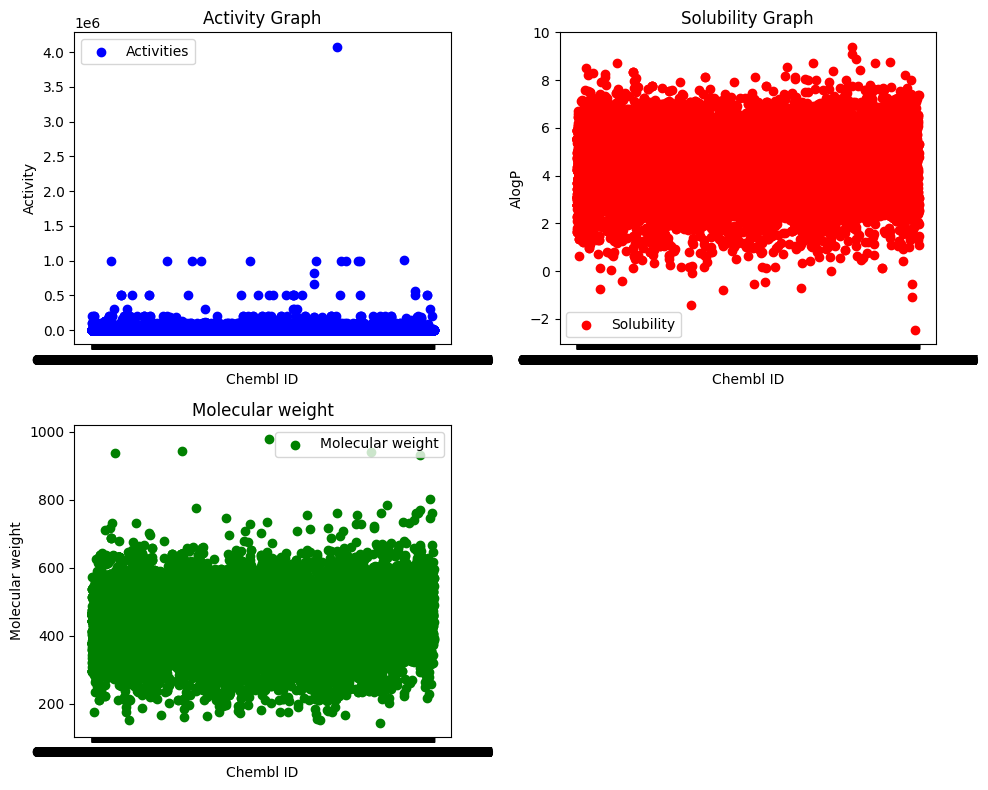

In [5]:
# random_indices = np.random.choice(data.index, 20, replace=False)
# random_rows = data.loc[random_indices]

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot the first scatter plot in the top-left subplot
axs[0, 0].scatter(data["Molecule ChEMBL ID"], data["Standard Value"], c='b', label='Activities')
axs[0, 0].set_title('Activity Graph')
x_ticks = np.arange(1, 18799, 10000)  # Example: Show every 2nd tick
plt.xticks(x_ticks,rotation=90)
axs[0, 0].set_xlabel('Chembl ID')
axs[0, 0].set_ylabel('Activity')
axs[0, 0].legend()

# Plot the second scatter plot in the top-right subplot
axs[0, 1].scatter(data['Molecule ChEMBL ID'], data["AlogP"], c='r', label='Solubility')
axs[0, 1].set_title('Solubility Graph')
x_ticks = np.arange(1, 18799, 10000)  # Example: Show every 2nd tick
plt.xticks(x_ticks,rotation=90)
axs[0, 1].set_xlabel('Chembl ID')
axs[0, 1].set_ylabel('AlogP')
axs[0, 1].legend()

# Plot the third scatter plot in the bottom-left subplot
axs[1, 0].scatter(data["Molecule ChEMBL ID"], data["Molecular Weight"], c='g', label='Molecular weight')
axs[1, 0].set_title('Molecular weight')
x_ticks = np.arange(1, 18799, 1000)  # Example: Show every 2nd tick
plt.xticks(x_ticks,rotation=90)
axs[1, 0].set_xlabel('Chembl ID')
axs[1, 0].set_ylabel('Molecular weight')
axs[1, 0].legend()

fig.delaxes(axs[1, 1])
# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

In [19]:
smiles_list = data['Smiles']
smiles_list

0                 O=C(Nc1ccc(Cl)cc1)c1ccccc1Cn1ccc2cccnc21
1        COc1cc(C2=C(c3c[nH]c4ccccc34)C(=O)NC2=O)cc(OC)...
2         O=C(Nc1ccc(-c2ccccc2)cc1)c1ccccc1Cn1ccc2ncnc-2c1
3        COc1cc2nccc(Oc3ccc4c(C(=O)NC5CCCC5)cccc4c3)c2c...
4        COCCNC(=O)c1cccc2cc(Oc3ccnc4cc(OC)c(C(C)=O)cc3...
                               ...                        
15480                          O=C(CCCCCCC(=O)Nc1ccccc1)NO
15481    COc1cc2/c(=N/c3ccc(Br)cc3F)nc[nH]c2cc1OCC1CCN(...
15482    Cc1cnc(C#Cc2ccc3c4c(oc3c2)C(C)(C)c2cc(NS(C)(=O...
15483    COc1cc2ncnc(Sc3cccc(NC(=S)Nc4ccc(Br)c(C(F)(F)F...
15484    CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...
Name: Smiles, Length: 15485, dtype: object

In [20]:
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
def smiles_encoder(compound, maxlen=295):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(compound))
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

one_hot_list = []
for i in range(len(smiles_list)):
    mat=smiles_encoder(smiles_list[i])
    one_hot_list.append(mat)

In [21]:
X = one_hot_list
y = data[['Standard Value',"AlogP","Molecular Weight"]].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [22]:
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# Step 3: Create DataLoader for each split
batch_size = 64  # Adjust the batch size as needed
# packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset)
test_loader = DataLoader(test_dataset)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class LSTM_Net(nn.Module):
    def __init__(self):
        super(LSTM_Net, self).__init__()

        # length = dims[0]
        # number_tokens = dims[1]


        self.lstm = nn.LSTM(input_size=56, hidden_size=64, num_layers=1, batch_first=True, bidirectional=False)
        self.fc1 = nn.Linear(64, 32) # Output layer
        self.activation = nn.ReLU() # Non-Linear ReLU Layer       
        self.fc_out = nn.Linear(32, 3) # Output layer
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):# Forward pass: stacking each layer together
        
        out, (h_n, c_n) = self.lstm(x) #LSTM network reads in one-hot-encoded SMILES, h_n is last output, out is for all timesteps
        out = self.dropout(h_n) #Dropout
        out = self.fc1(out) # Pass into the hidden layer
        out = self.activation(out) # Use ReLU on hidden activation
        out = self.dropout(out) # dropout
        out = self.fc_out(out) # Use a linear layer for the output
        return out

In [25]:
model = LSTM_Net().to(torch.float32)
loss_type = MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.004, weight_decay=0.05)
epochs = 20

In [26]:
steps = 0
loss_list = []
val_loss_list = []
for epoch in range(epochs):
    total = 0
    correct = 0
    with tqdm(train_loader, unit="batch") as tepoch:
        for data, labels in tepoch:
            steps+=1
            data , labels = data.to(torch.float32) , labels.to(torch.float32)
            optimizer.zero_grad()
            output = model(data)
            loss = loss_type(output,labels.view(output.shape))
            loss.backward()
            optimizer.step()
            loss_list.append(loss.detach().cpu().numpy())
            tepoch.set_postfix(loss=loss.item())

    # Calculate validation metrics without a nested tqdm
    val_loss = 0.0  # Initialize validation loss
    num_samples = 0  # Count of validation samples
    val_loss_type = L1Loss()
    with torch.no_grad():
        for data, labels in val_loader:
            data, labels = data.to(torch.float32), labels.to(torch.float32)
            output = model(data)
            val_loss = val_loss_type(output, labels.view(output.shape))
            num_samples += len(data)
            val_loss_list.append(val_loss.detach().cpu().numpy())

        # val_loss /= num_samples  # Calculate average validation loss
        print(f'Validation Mean absolute error loss after Epoch {epoch + 1}: {val_loss/num_samples:.4f}')

100%|██████████| 175/175 [00:12<00:00, 14.49batch/s, loss=6.15e+3]


Validation Mean absolute error loss after Epoch 1: 0.0076


100%|██████████| 175/175 [00:11<00:00, 15.19batch/s, loss=5.84e+3]


Validation Mean absolute error loss after Epoch 2: 0.0026


100%|██████████| 175/175 [00:11<00:00, 14.87batch/s, loss=2.58e+3]


Validation Mean absolute error loss after Epoch 3: 0.0014


100%|██████████| 175/175 [00:11<00:00, 15.02batch/s, loss=2.97e+3]


Validation Mean absolute error loss after Epoch 4: 0.0205


100%|██████████| 175/175 [00:11<00:00, 15.06batch/s, loss=3.15e+3]


Validation Mean absolute error loss after Epoch 5: 0.0247


100%|██████████| 175/175 [00:11<00:00, 15.29batch/s, loss=3.78e+3]


Validation Mean absolute error loss after Epoch 6: 0.0145


100%|██████████| 175/175 [00:11<00:00, 15.14batch/s, loss=5.36e+3]


Validation Mean absolute error loss after Epoch 7: 0.0271


100%|██████████| 175/175 [00:11<00:00, 14.86batch/s, loss=5.16e+3]


Validation Mean absolute error loss after Epoch 8: 0.0103


100%|██████████| 175/175 [00:11<00:00, 15.15batch/s, loss=4.2e+3] 


Validation Mean absolute error loss after Epoch 9: 0.0313


100%|██████████| 175/175 [00:12<00:00, 14.41batch/s, loss=2.33e+3]


Validation Mean absolute error loss after Epoch 10: 0.0074


100%|██████████| 175/175 [00:11<00:00, 15.04batch/s, loss=6.93e+3]


Validation Mean absolute error loss after Epoch 11: 0.0130


100%|██████████| 175/175 [00:11<00:00, 15.20batch/s, loss=6.41e+3]


Validation Mean absolute error loss after Epoch 12: 0.0143


100%|██████████| 175/175 [00:11<00:00, 14.79batch/s, loss=1.6e+3] 


Validation Mean absolute error loss after Epoch 13: 0.0152


100%|██████████| 175/175 [00:11<00:00, 15.11batch/s, loss=2.03e+3]


Validation Mean absolute error loss after Epoch 14: 0.0516


100%|██████████| 175/175 [00:11<00:00, 15.39batch/s, loss=1.62e+3]


Validation Mean absolute error loss after Epoch 15: 0.0185


100%|██████████| 175/175 [00:11<00:00, 14.67batch/s, loss=7.48e+3]


Validation Mean absolute error loss after Epoch 16: 0.0108


100%|██████████| 175/175 [00:11<00:00, 15.57batch/s, loss=2.92e+3]


Validation Mean absolute error loss after Epoch 17: 0.0376


100%|██████████| 175/175 [00:11<00:00, 15.20batch/s, loss=4.66e+3]


Validation Mean absolute error loss after Epoch 18: 0.0088


100%|██████████| 175/175 [00:11<00:00, 15.40batch/s, loss=3.68e+3]


Validation Mean absolute error loss after Epoch 19: 0.0131


100%|██████████| 175/175 [00:11<00:00, 15.41batch/s, loss=3.28e+3]


Validation Mean absolute error loss after Epoch 20: 0.0132


In [27]:
test_loss_list = []
test_loss_type = L1Loss()
with torch.no_grad():
    for data, test_labels in test_loader:
        data, test_labels = data.to(torch.float32), test_labels.to(torch.float32)
        output = model(data)
        output = torch.reshape(output, (output.shape[1],3))
        mae = torch.sum(torch.abs(output-test_labels),dim =0) # mean absolute error
        num_samples += len(data)
    # val_loss /= num_samples  # Calculate average validation loss
    mae_list = (mae/num_samples).detach().cpu().numpy().tolist()
    print(f'Validation Mean absolute error loss for activity, solubility and molecular weight respectively are {mae_list}')


Validation Mean absolute error loss for activity, solubility and molecular weight respectively are [8.708933455636725e-05, 0.0002535564999561757, 0.03731079399585724]


## Traditional ML technique: Random Forest Regression

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from rdkit import Chem
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [31]:
path = '/home/shrestha/python_project/datasets/biopharma_activity.csv'
data = pd.read_csv(path , on_bad_lines='skip')
# data = pd.read_csv(path , error_bad_lines=False) #IF ABOVE LINE GIVES ERROR UNCOMMENT THIS LINE AND COMMENT OUT ABOVE LINE AND THEN RUN
data = data.dropna(subset=['Smiles','Standard Value','Molecular Weight','AlogP','Standard Units'])
data.reset_index(drop=True, inplace=True)
data.head()

,Molecule ChEMBL ID,Molecule Name,Molecule Max Phase,Molecular Weight,#RO5 Violations,AlogP,Compound Key,Smiles,Standard Type,Standard Relation,...,Target Organism,Target Type,Document ChEMBL ID,Source ID,Source Description,Document Journal,Document Year,Cell ChEMBL ID,Properties,Action Type
0,CHEMBL205876,NaN,NaN,361.83,0.0,4.99,9,O=C(Nc1ccc(Cl)cc1)c1ccccc1Cn1ccc2cccnc21,IC50,>',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1139022,1,Scientific Literature,Bioorg Med Chem Lett,2006.0,NaN,NaN,NaN
1,CHEMBL201090,NaN,NaN,406.39,0.0,3.39,16a,COc1ccc2[nH]c3c4c(OC)c(OC)c(OC)cc4c4c(c3c2c1)C...,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
2,CHEMBL202196,NaN,NaN,338.37,0.0,3.89,20,O=C1NC(=O)C(c2c[nH]c3ccccc23)=C1c1cccc2ccccc12,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
3,CHEMBL201463,NaN,NaN,392.41,0.0,3.07,18,COc1cc(C2=C(c3c(C)[nH]c4ccccc34)C(=O)NC2=O)cc(...,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN
4,CHEMBL372944,NaN,NaN,339.35,0.0,2.28,5,COc1cc(C2=C(c3ccccc3)C(=O)NC2=O)cc(OC)c1OC,Inhibition,=',...,Homo sapiens,SINGLE PROTEIN,CHEMBL1149451,1,Scientific Literature,J Med Chem,2006.0,CHEMBL3308860,NaN,NaN


In [32]:
unique_units = data['Standard Units'].unique()  #finding different units of solubility present in our data
print(unique_units)

#we can only use nM, %, uM, ug.mL-1, we drop all other values 
units_to_drop = ['%', 'hr',  'ug.mL-1', "10'-4No_unit", 'degrees C', "10'-3/s",
                 "10'5/M/s", '% ID/g', 'equiv']
data = data[~data["Standard Units"].isin(units_to_drop)]
data.reset_index(drop=True, inplace=True)
data['Standard Value'] = data.apply(lambda row:
                                    row['Standard Value'] * 1000 if row['Standard Units'] in ('µM','uM') else row['Standard Value'],axis=1)

data["Standard Units"] = 'nM'

['nM' '%' 'hr' 'uM' 'ug.mL-1' "10'-4No_unit" 'degrees C' "10'-3/s"
 "10'5/M/s" '% ID/g' 'µM' 'equiv']


In [ ]:
smiles_list = data['Smiles']
SMILES_CHARS = [' ',
                '#', '%', '(', ')', '+', '-', '.', '/',
                '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
                '=', '@',
                'A', 'B', 'C', 'F', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P',
                'R', 'S', 'T', 'V', 'X', 'Z',
                '[', '\\', ']',
                'a', 'b', 'c', 'e', 'g', 'i', 'l', 'n', 'o', 'p', 'r', 's',
                't', 'u']
smi2index = dict( (c,i) for i,c in enumerate( SMILES_CHARS ) )
index2smi = dict( (i,c) for i,c in enumerate( SMILES_CHARS ) )
def smiles_encoder(compound, maxlen=295):
    smiles = Chem.MolToSmiles(Chem.MolFromSmiles(compound))
    X = np.zeros( ( maxlen, len( SMILES_CHARS ) ) )
    for i, c in enumerate( smiles ):
        X[i, smi2index[c] ] = 1
    return X

one_hot_list = []
for i in range(len(smiles_list)):
    mat=smiles_encoder(smiles_list[i])
    one_hot_list.append(mat)

In [33]:
X = one_hot_list
y = data['Standard Value'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [34]:
X_train = np.reshape(np.array(X_train),(11149,295*56))

In [35]:
X_train.shape

(11149, 16520)

In [36]:
regressor = RandomForestRegressor(random_state=1234)
regressor.fit(X_train,y_train)

RandomForestRegressor(random_state=1234)

In [37]:
# With our optimal settings found, we can use the optimal parameter setting to make predictions
predictions = regressor.predict(np.reshape(np.array(X_test),(3097,295*56)))

# View the scoring results of these predictions and review performance

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(y_test ,predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

Mean Absolute Error: 8370.439524952775
Mean Squared Error: 2255624453.0543413
Root Mean Squared Error: 47493.41483884204
